In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px

import sklearn as sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import precision_score, f1_score, recall_score

In [2]:
# Load processed data features
data_features = pd.read_csv('processed_data/data_features.csv', header=[0,1], index_col=0, parse_dates=True)
# Forward fill missing values
data_features = data_features.ffill()

# Quick look at the data
print('features :' + str(data_features.keys().get_level_values(1).unique()))
data_features.head()

features :Index(['Stochastic', 'William', 'Basic_Mid', 'Close_to_High', 'Close_to_Low',
       'DD_Return', 'Close_MA_5', 'Close_STD_5', 'Close_GROWTH_5',
       'Close_MA_10', 'Close_STD_10', 'Close_GROWTH_10', 'Close_MA_15',
       'Close_STD_15', 'Close_GROWTH_15', 'Close_MA_35', 'Close_STD_35',
       'Close_GROWTH_35', 'Close_MA_40', 'Close_STD_40', 'Close_GROWTH_40',
       'Close_MA_45', 'Close_STD_45', 'Close_GROWTH_45', 'High_MA_5',
       'High_STD_5', 'High_GROWTH_5', 'High_MA_10', 'High_STD_10',
       'High_GROWTH_10', 'High_MA_15', 'High_STD_15', 'High_GROWTH_15',
       'High_MA_35', 'High_STD_35', 'High_GROWTH_35', 'High_MA_40',
       'High_STD_40', 'High_GROWTH_40', 'High_MA_45', 'High_STD_45',
       'High_GROWTH_45', 'Low_MA_5', 'Low_STD_5', 'Low_GROWTH_5', 'Low_MA_10',
       'Low_STD_10', 'Low_GROWTH_10', 'Low_MA_15', 'Low_STD_15',
       'Low_GROWTH_15', 'Low_MA_35', 'Low_STD_35', 'Low_GROWTH_35',
       'Low_MA_40', 'Low_STD_40', 'Low_GROWTH_40', 'Low_MA_45', 'L

CDE                                                  \
           Stochastic   William  Basic_Mid Close_to_High Close_to_Low   
Date                                                                    
2005-01-03   0.090908  0.909092  38.100000      0.026455    -0.002645   
2005-01-04   0.142857  0.857143  36.600000      0.049862    -0.008310   
2005-01-05   0.125001  0.874999  36.300001      0.038997    -0.005571   
2005-01-06   0.210527  0.789473  35.366666      0.042857    -0.011429   
2005-01-07   0.499998  0.500002  35.300001      0.016997    -0.016997   

                                                                        ...  \
           DD_Return Close_MA_5 Close_STD_5 Close_GROWTH_5 Close_MA_10  ...   
Date                                                                    ...   
2005-01-03       NaN        NaN         NaN            NaN         NaN  ...   
2005-01-04 -0.044974        NaN         NaN            NaN         NaN  ...   
2005-01-05 -0.005540        NaN         NaN            NaN         NaN  ...   
2005-01-06 -0.025070        NaN         NaN            NaN         NaN  ...   
2005-01-07  0.008571   1.020397    0.030247            NaN         NaN  ...   

                    LRCX                                          \
           Low_TREND_150 Low_STD_150 Low_GROWTH_150 Close_CORR_5   
Date                                                               
2005-01-03           NaN         NaN            NaN          NaN   
2005-01-04           NaN         NaN            NaN          NaN   
2005-01-05           NaN         NaN            NaN          NaN   
2005-01-06           NaN         NaN            NaN          NaN   
2005-01-07           NaN         NaN            NaN          NaN   

                                                                    \
           Close_CORR_10 Close_CORR_15 Close_CORR_35 Close_CORR_40   
Date                                                                 
2005-01-03           NaN           NaN           NaN           NaN   
2005-01-04           NaN           NaN           NaN           NaN   
2005-01-05           NaN           NaN           NaN           NaN   
2005-01-06           NaN           NaN           NaN           NaN   
2005-01-07           NaN           NaN           NaN           NaN   

                                 
           Close_CORR_45 Signal  
Date                             
2005-01-03           NaN      0  
2005-01-04           NaN     -1  
2005-01-05           NaN     -1  
2005-01-06           NaN     -1  
2005-01-07           NaN      0  

[5 rows x 12972 columns]

In [3]:
# Filter data_features to include only rows after the date N due to feature availability
N = 151
filtered_data = data_features[data_features.index > data_features.index[N]]
last_date = filtered_data.index.max()
print(f"Data filtered to include only rows before {last_date}")

Data filtered to include only rows before 2025-09-29 00:00:00


In [40]:
# Fit model and parameters for each period and ticker

duration_period = 0.5 # % year
window_size = int(252* duration_period)
trigger_up_grid = np.linspace(0.01, 0.99, 10)
trigger_down_grid = np.linspace(-0.01, -0.99, 10)

filtered_data = filtered_data.ffill()
tickers = filtered_data.columns.get_level_values(0).unique()

dates = filtered_data.index.unique()
time_splits = range(0, len(filtered_data) - 2 * window_size, window_size)

metrics_perf = []

for start in time_splits:
    print(f"Processing period starting at index {start}, date {filtered_data.index[start]}")
    end = start + 2 * window_size
    train_data = filtered_data.iloc[start:start + window_size]
    test_data = filtered_data.iloc[start + window_size:end]

    for ticker in tickers:
        # Prepare training and testing datasets
        X_train = train_data[ticker].drop(columns=['Signal'])
        Y_train = train_data[ticker]['Signal']

        X_test = test_data[ticker].drop(columns=['Signal'])
        Y_test = test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit model (e.g., Linear Regression)
        model = LinearRegression()
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_pred_train_source = model.predict(X_train_scaled)
        Y_pred_test_source = model.predict(X_test_scaled)

        best_tup = None
        best_tdown = None
        best_return_train = -np.inf
        return_predicted_train = 0.0
        return_predicted_test = 0.0

        for trigger_up_grid_value in trigger_up_grid:
            #print(f"  Evaluating triggers: Up={trigger_up_grid_value} | Down=", end="")
            for trigger_down_grid_value in trigger_down_grid:
                tup = trigger_up_grid_value
                tdown = trigger_down_grid_value
                #print(f"{tdown} / ", end=" ")

                Y_pred_train = np.where(Y_pred_train_source > tup, 1, np.where(Y_pred_train_source < tdown, -1, 0))
                Y_pred_test = np.where(Y_pred_test_source > tup, 1, np.where(Y_pred_test_source < tdown, -1, 0))

                # Evaluate performance
                Return = np.array(X_test.DD_Return.shift(-1).fillna(0))
                return_predicted_train = float(np.sum(Y_pred_train * X_train.DD_Return.shift(-1).fillna(0)))
                return_predicted_test = float(np.sum(Y_pred_test * Return))
                if return_predicted_train > best_return_train:
                    best_return_train = return_predicted_train
                    best_tup = tup
                    best_tdown = tdown
            #print("")

        metrics_perf.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': return_predicted_train,
            'Return_Predicted_Test': return_predicted_test,
            'Train < Test': 1 if return_predicted_train < return_predicted_test else 0,
            'Trigger_Up': best_tup,
            'Trigger_Down': best_tdown,
        })
        
metrics_perf_df = pd.DataFrame(metrics_perf)
metrics_perf_df.to_csv('processed_data/linear_model_metrics_performance_0.csv', index=False)
metrics_perf_df.head()

Processing period starting at index 0, date 2005-08-10 00:00:00
Processing period starting at index 126, date 2006-02-09 00:00:00
Processing period starting at index 252, date 2006-08-10 00:00:00
Processing period starting at index 378, date 2007-02-12 00:00:00
Processing period starting at index 504, date 2007-08-13 00:00:00
Processing period starting at index 630, date 2008-02-12 00:00:00
Processing period starting at index 756, date 2008-08-12 00:00:00
Processing period starting at index 882, date 2009-02-11 00:00:00
Processing period starting at index 1008, date 2009-08-12 00:00:00
Processing period starting at index 1134, date 2010-02-11 00:00:00
Processing period starting at index 1260, date 2010-08-12 00:00:00
Processing period starting at index 1386, date 2011-02-10 00:00:00
Processing period starting at index 1512, date 2011-08-11 00:00:00
Processing period starting at index 1638, date 2012-02-10 00:00:00
Processing period starting at index 1764, date 2012-08-10 00:00:00
Proce

,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Train < Test,Trigger_Up,Trigger_Down
0,CDE,2005-08-10,2006-02-08,2006-02-09,2006-08-09,0.217058,-0.134447,0,0.881111,-0.990000
1,ORCL,2005-08-10,2006-02-08,2006-02-09,2006-08-09,-0.096571,0.032353,1,0.445556,-0.990000
2,AMZN,2005-08-10,2006-02-08,2006-02-09,2006-08-09,0.115918,0.319043,1,0.010000,-0.227778
3,ASX,2005-08-10,2006-02-08,2006-02-09,2006-08-09,0.087231,0.438473,1,0.010000,-0.772222
4,PTEN,2005-08-10,2006-02-08,2006-02-09,2006-08-09,0.157030,-0.027636,0,0.881111,-0.772222


In [41]:
Train_start_list = metrics_perf_df['Train Start'].unique().tolist()
Ticker_per_Period = {}

In [42]:
quantile_above = 0.90
for train_start in Train_start_list:
    quantile_n = metrics_perf_df[metrics_perf_df['Train Start'] == train_start].Return_Predicted_Train.quantile(quantile_above)
    selected_tickers = metrics_perf_df[(metrics_perf_df['Train Start'] == train_start) &
                                       (metrics_perf_df['Return_Predicted_Train'] >= quantile_n)]['Ticker'].tolist()
    Ticker_per_Period[train_start] = selected_tickers

In [47]:
# Rerun with selected tickers only based on top quantile performance during training

metrics_perf_selected = []

for start in time_splits:
    print(f"Processing period starting at index {start}, date {filtered_data.index[start]}")
    end = start + 2 * window_size
    train_data = filtered_data.iloc[start:start + window_size]
    test_data = filtered_data.iloc[start + window_size:end]

    for ticker in Ticker_per_Period[filtered_data.index[start]]:
        # Prepare training and testing datasets
        X_train = train_data[ticker].drop(columns=['Signal'])
        Y_train = train_data[ticker]['Signal']

        X_test = test_data[ticker].drop(columns=['Signal'])
        Y_test = test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit model (e.g., Linear Regression)
        model = LinearRegression()
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_pred_train = model.predict(X_train_scaled)
        Y_pred_test = model.predict(X_test_scaled)

        t_up = metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) & (metrics_perf_df['Train Start'] == filtered_data.index[start])]['Trigger_Up'].values[0]
        t_down = metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) & (metrics_perf_df['Train Start'] == filtered_data.index[start])]['Trigger_Down'].values[0]

        Y_pred_train = np.where(Y_pred_train > t_up, 1, np.where(Y_pred_train < t_down, -1, 0))
        Y_pred_test = np.where(Y_pred_test > t_up, 1, np.where(Y_pred_test < t_down, -1, 0))

        # Evaluate performance
        Return = np.array(X_test.DD_Return.shift(-1).fillna(0))
        return_predicted_train = float(np.sum(Y_pred_train * X_train.DD_Return.shift(-1).fillna(0)))
        return_predicted_test = float(np.sum(Y_pred_test * Return))

        metrics_perf_selected.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': return_predicted_train,
            'Return_Predicted_Test': return_predicted_test,
            'Train < Test': 1 if return_predicted_train < return_predicted_test else 0,
            'Trigger_Up': t_up,
            'Trigger_Down': t_down,
        })
        
metrics_perf_selected_df = pd.DataFrame(metrics_perf_selected)

Processing period starting at index 0, date 2005-08-10 00:00:00
Processing period starting at index 126, date 2006-02-09 00:00:00
Processing period starting at index 252, date 2006-08-10 00:00:00
Processing period starting at index 378, date 2007-02-12 00:00:00
Processing period starting at index 504, date 2007-08-13 00:00:00
Processing period starting at index 630, date 2008-02-12 00:00:00
Processing period starting at index 756, date 2008-08-12 00:00:00
Processing period starting at index 882, date 2009-02-11 00:00:00
Processing period starting at index 1008, date 2009-08-12 00:00:00
Processing period starting at index 1134, date 2010-02-11 00:00:00
Processing period starting at index 1260, date 2010-08-12 00:00:00
Processing period starting at index 1386, date 2011-02-10 00:00:00
Processing period starting at index 1512, date 2011-08-11 00:00:00
Processing period starting at index 1638, date 2012-02-10 00:00:00
Processing period starting at index 1764, date 2012-08-10 00:00:00
Proce

In [48]:
metrics_perf_selected_df.to_csv('model/linear/metrics_performance_selected.csv', index=False)

In [55]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
metrics_summary = metrics_perf_selected_df.groupby('Train Start').agg({
    'Return_Predicted_Train': 'mean',
    'Return_Predicted_Test': 'mean',
})

summary_graph = metrics_perf_selected_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Return_Predicted_Test': 'mean',
})
summary_graph.to_csv('model/linear/metrics_summary.csv', index=True)

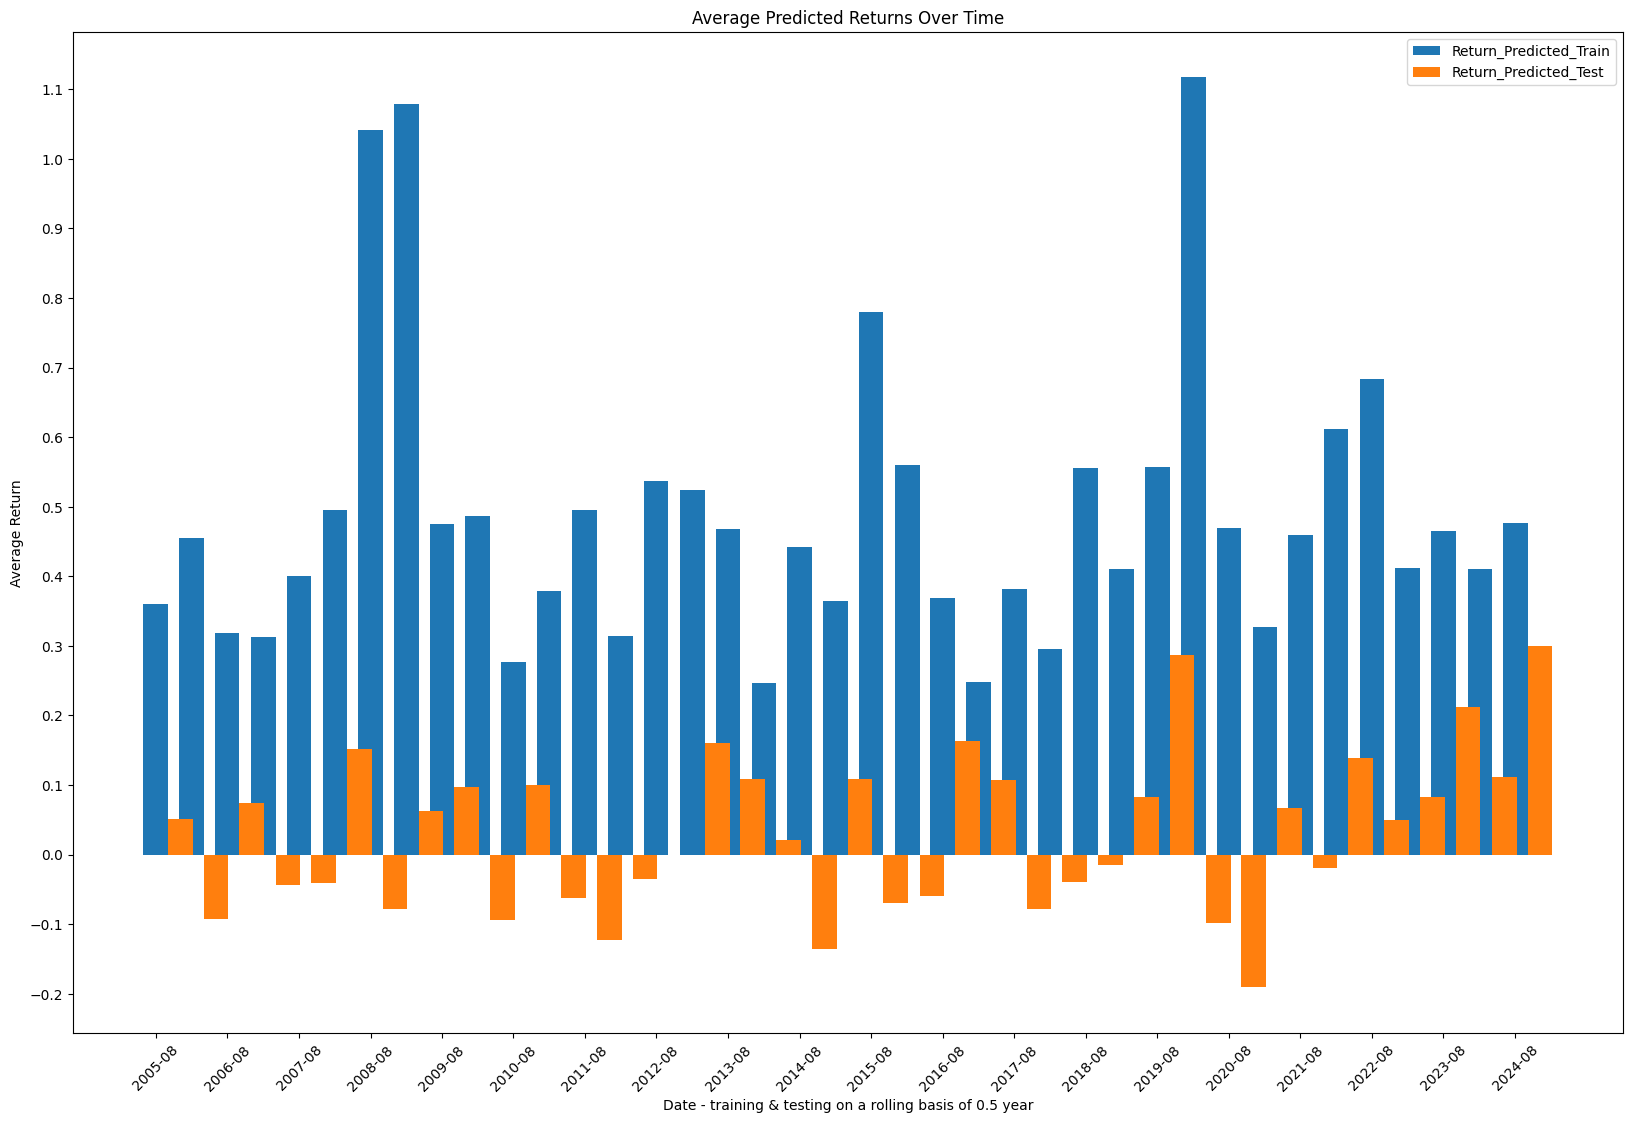

In [50]:
plt.figure(figsize=(20, 13))
plt.bar(metrics_summary.index - pd.Timedelta(days=0), metrics_summary['Return_Predicted_Train'], width=252*duration_period, label='Return_Predicted_Train', alpha=1)
plt.bar(metrics_summary.index + pd.Timedelta(days=252*duration_period), metrics_summary['Return_Predicted_Test'], width=252*duration_period, label='Return_Predicted_Test', alpha=1)
plt.xlabel(f'Date - training & testing on a rolling basis of {round(duration_period, 3)} year{"s" if duration_period > 1 else ""}')
plt.ylabel('Average Return')
tick_positions = metrics_summary.index[::2]  # Every n ticks
tick_labels = [d.strftime('%Y-%m') for d in tick_positions]  # Format as Year-Month
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.yticks(np.arange(round(min(metrics_summary.min()) * 1.1, 1), round(max(metrics_summary.max()) * 1.1, 1), 0.1))  # Ticks from -1.0 to 1.0 in 0.1 steps
plt.title('Average Predicted Returns Over Time')
plt.legend()
plt.show()